In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
import constants as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2040
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [2]:
#load modeled, FAF and CFS results
# print(c.cfs_distribution_file)
output_dir = 'outputs_SF_2040/'
param_dir = 'Parameter_SF/'
plot_dir = 'plots_SF_2040/'

faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')

modeled_data = read_csv(output_dir + 'processed_b2b_flow_summary.csv', sep = ',')
modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']
#load parameters
sctg_group_lookup = read_csv(param_dir + 'SCTG_Groups_revised.csv', sep = ',')
mesozone_lookup = read_csv(param_dir + 'zonal_id_lookup_final.csv', sep = ',')
sctg_definition = read_csv(param_dir + 'SCTG_definition.csv', sep = ',')

sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

In [3]:
# process faf data for validation
region_code = [62, 64, 65, 69]
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
# faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == 1] #select domestic shipment only
bay_area_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(region_code)]
bay_area_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(region_code)]
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description,Unnamed: 4,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,7763605.0,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live),NaN,62.055467
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,96869428.0,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live),NaN,124.036281
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,638719.0,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live),NaN,325.380006
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3394250.0,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live),NaN,171.440007
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,2141527.0,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live),NaN,244.231744


In [4]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
modeled_bay_area_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
modeled_bay_area_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
4,4,12.0,Mobile,64.0,San Francisco,4.0,mfr_goods,Air,1.618727e+05,0.081167,103,0,1,1994.322103
5,5,12.0,Mobile,64.0,San Francisco,4.0,mfr_goods,For-hire Truck,1.154488e+07,4.201760,5332,0,1,2747.630000
6,6,12.0,Mobile,64.0,San Francisco,4.0,mfr_goods,Rail/IMX,2.932266e+05,0.111112,141,0,1,2639.022545
7,7,12.0,Mobile,69.0,Rest of CA,4.0,mfr_goods,Air,1.392935e+03,0.000731,6,0,1,1906.180417
8,8,12.0,Mobile,69.0,Rest of CA,4.0,mfr_goods,For-hire Truck,1.381688e+04,0.004993,41,0,1,2767.010000


interm_food


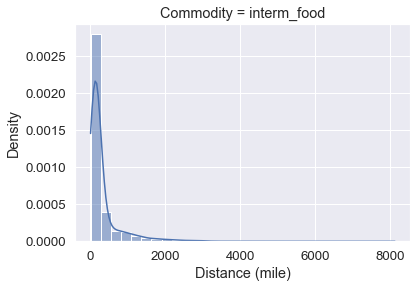

bulk


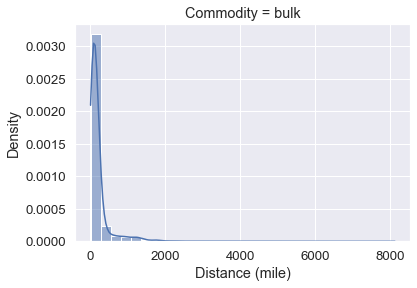

mfr_goods


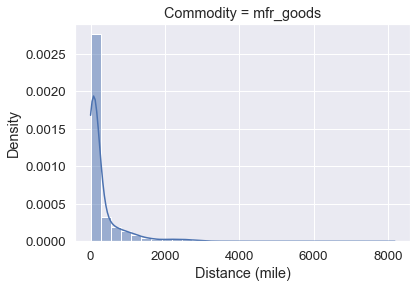

fuel_fert


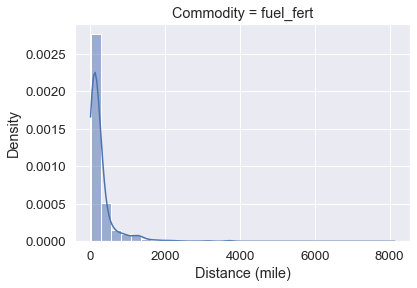

other


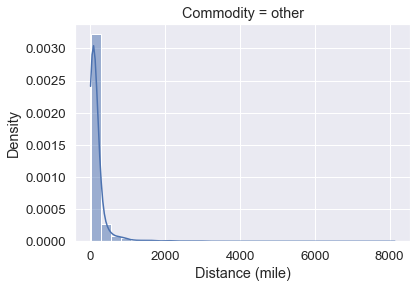

In [5]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck


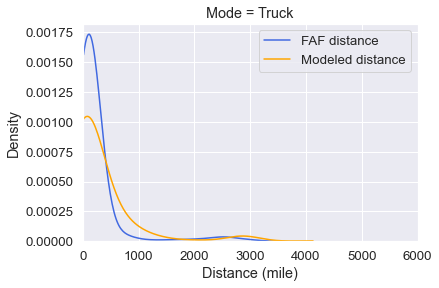

Rail


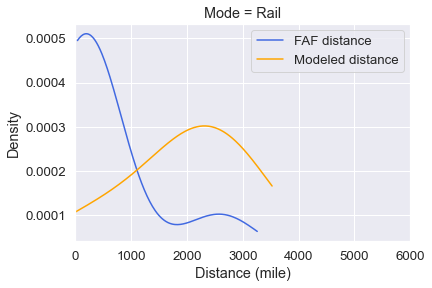

Air


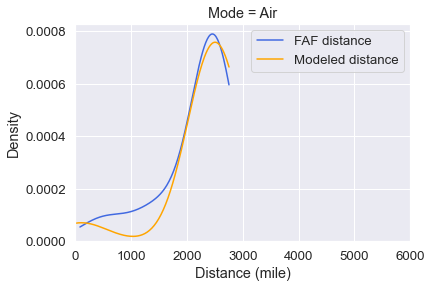

Parcel


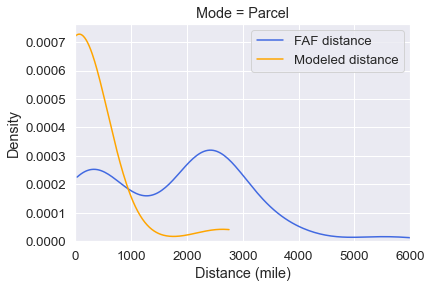

Truck


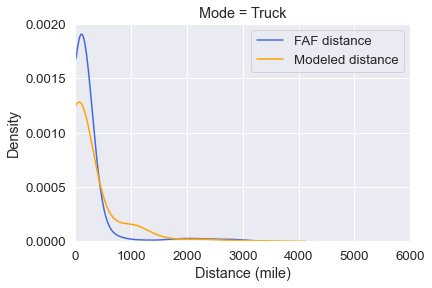

Rail


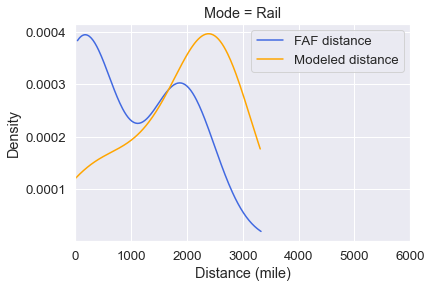

Air


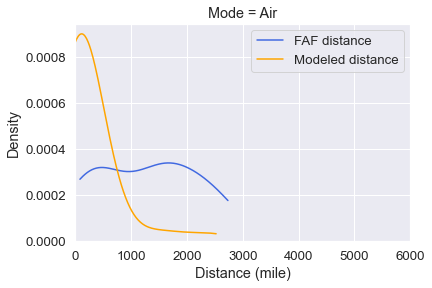

Parcel


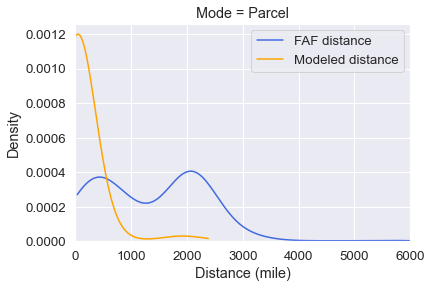

In [6]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}

mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_bay_area_outflow.loc[modeled_bay_area_outflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_outflow.loc[bay_area_outflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')     
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'outflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_outflow_distance_statistics_by_mode.csv')

# attraction
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_inflow.loc[bay_area_inflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'inflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

FAF shipment        668610.321544
Modeled shipment    192697.708577
dtype: float64
FAF tonmile        178314.210723
Modeled tonmile     91634.056763
dtype: float64


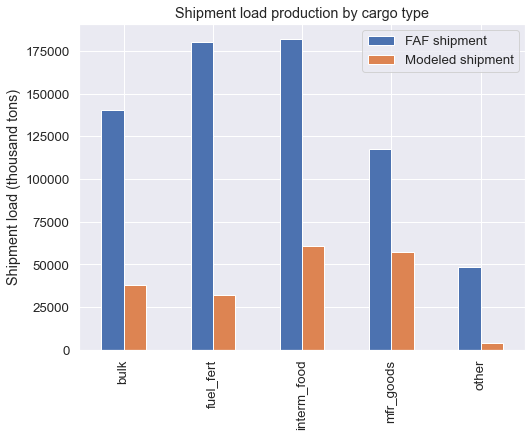

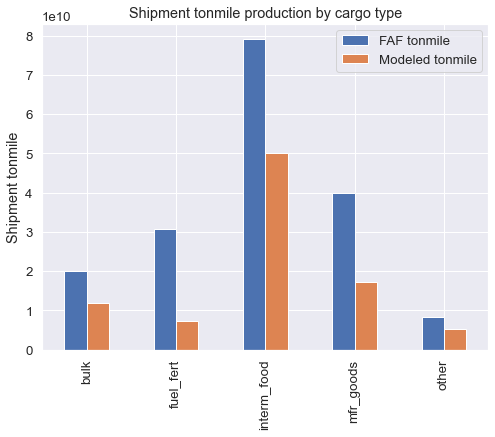

In [7]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = bay_area_outflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_bay_area_outflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()

shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']
print(shipment_generation_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_generation_by_sctg.plot(y = ['FAF shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()


shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

FAF shipment        1.145953e+06
Modeled shipment    1.051780e+06
dtype: float64
FAF tonmile        298783.470695
Modeled tonmile    305159.255341
dtype: float64


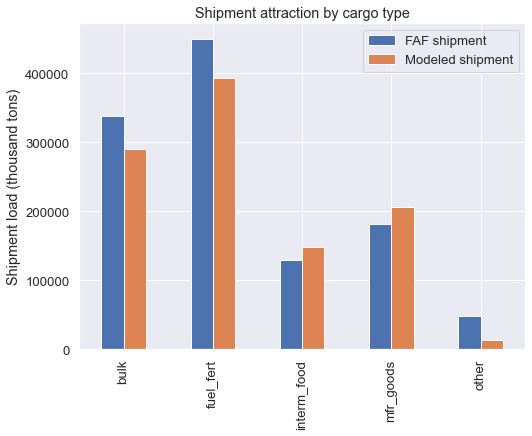

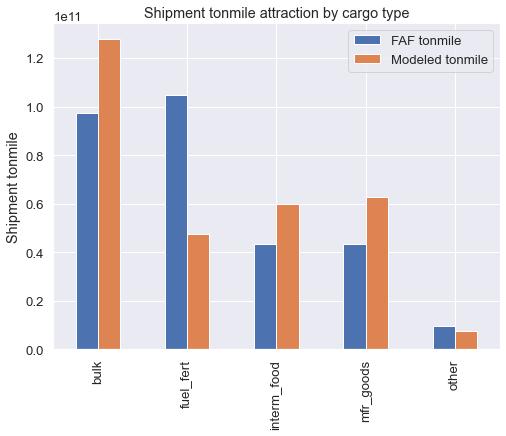

In [8]:
### plot shipment generation by commodity group
# data aggregation

FAF_shipment_by_sctg = bay_area_inflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_bay_area_inflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()


shipment_attraction_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']

print(shipment_attraction_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_attraction_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_attraction_by_sctg.plot(y = ['FAF shipment',  'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  title = 'Shipment attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'inflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'inflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

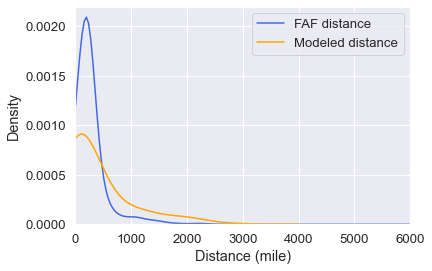

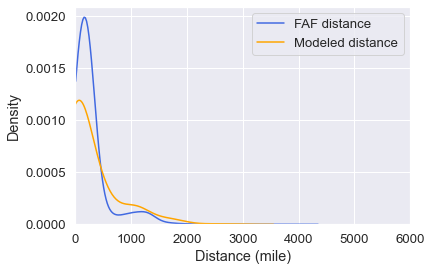

In [9]:
# KDE plot
sns.kdeplot(data = bay_area_outflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_bay_area_outflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.savefig('Plot_aus_' + str(analysis_year) + '/outflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()


sns.kdeplot(data = bay_area_inflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_bay_area_inflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.savefig('Plot_aus_' + str(analysis_year) + '/inflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()

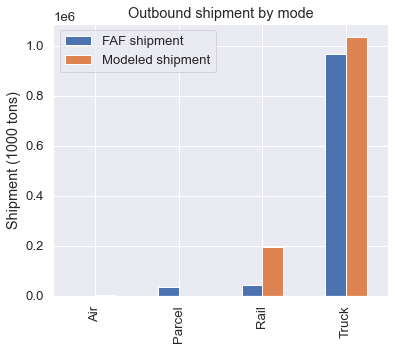

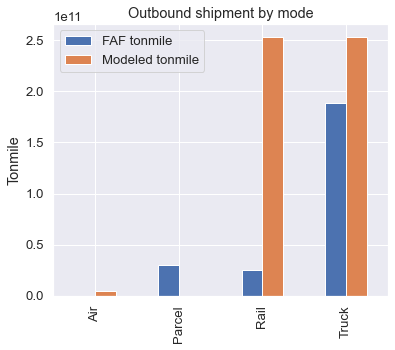

In [10]:
# plot shipment production by mode choice
model_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
modeled_bay_area_outflow.loc[:, 'mode_def'] = modeled_bay_area_outflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_outflow_by_mode = bay_area_outflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()

agg_modeled_outflow_by_mode = modeled_bay_area_outflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']
compare_outflow_by_mode = compare_outflow_by_mode.loc[compare_outflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'outflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'outflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(c.output_dir + 'outflow_shipment_by_mode_comparison.csv')

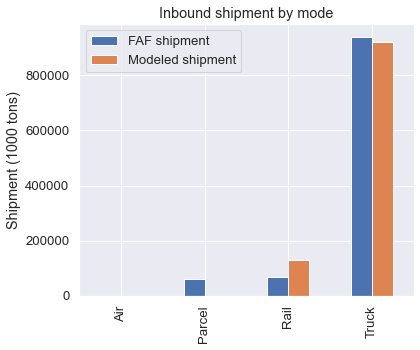

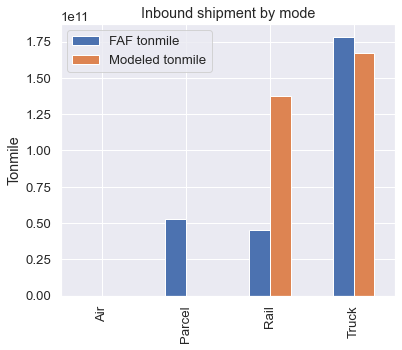

In [11]:
# plot shipment attraction by mode choice

modeled_bay_area_inflow.loc[:, 'mode_def'] = modeled_bay_area_inflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_inflow_by_mode = bay_area_inflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_mode = agg_faf_inflow_by_mode.reset_index()

agg_modeled_inflow_by_mode = modeled_bay_area_inflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_mode = agg_modeled_inflow_by_mode.reset_index()
compare_inflow_by_mode = pd.merge(agg_faf_inflow_by_mode, agg_modeled_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_inflow_by_mode.head(5)
compare_inflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']

compare_inflow_by_mode = compare_inflow_by_mode.loc[compare_inflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_mode.plot(x= 'mode_def', 
                            y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'inflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_inflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot_aus_' + str(analysis_year) + '/' + 'inflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_mode.to_csv(c.output_dir + 'inflow_shipment_by_mode_comparison.csv')

   orig_FAFID orig_FAFNAME  ShipmentLoad
0         481       Austin  6.808299e+04
1         488  San Antonio  1.407171e+05
2         489   Rest of TX  1.023442e+06


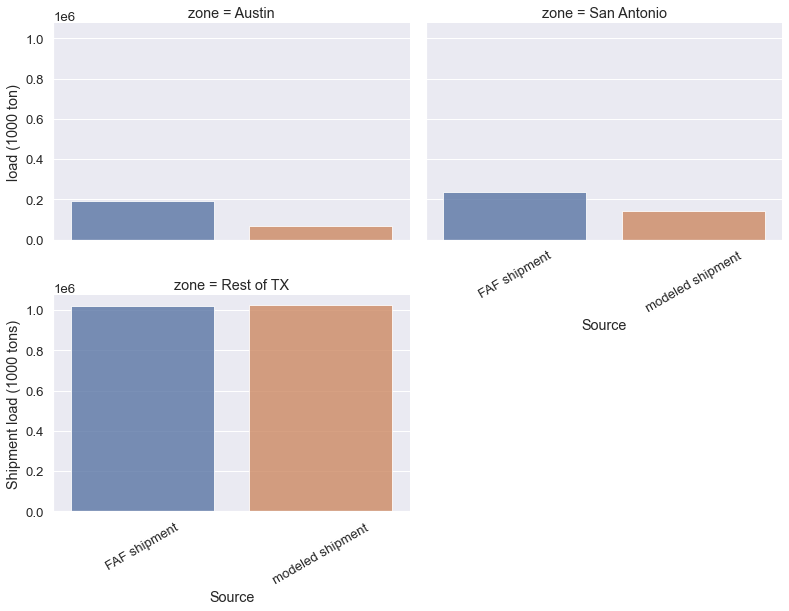

In [12]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_outflow_by_zone = bay_area_outflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_zone = agg_faf_outflow_by_zone.reset_index()
agg_modeled_outflow_by_zone = modeled_bay_area_outflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_by_zone = agg_modeled_outflow_by_zone.reset_index()
print(agg_modeled_outflow_by_zone)
                                                                      
compare_outflow_by_zone = pd.merge(agg_faf_outflow_by_zone, agg_modeled_outflow_by_zone, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')
compare_outflow_by_zone = compare_outflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_outflow_by_zone = pd.melt(compare_outflow_by_zone, 
                                    id_vars=['dms_orig', 'orig_FAFID', 'orig_FAFNAME'], 
                                    value_vars=['FAF shipment', 'modeled shipment'], 
                                    var_name = 'Source', ignore_index=False)
# print(compare_outflow_by_zone.head(5))

compare_outflow_by_zone = compare_outflow_by_zone.rename(columns = {'orig_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
ax = sns.catplot(
    data= compare_outflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot_aus_' + str(analysis_year) + '/outflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.ylabel('Shipment load (1000 tons)')
plt.show()
compare_outflow_by_zone.to_csv(c.output_dir + 'compare_outflow_by_zone_cfs_dded.csv', sep = ',')

   dest_FAFID dest_FAFNAME   ShipmentLoad
0         481       Austin  153071.244509
1         488  San Antonio  177543.747590
2         489   Rest of TX  721164.583739


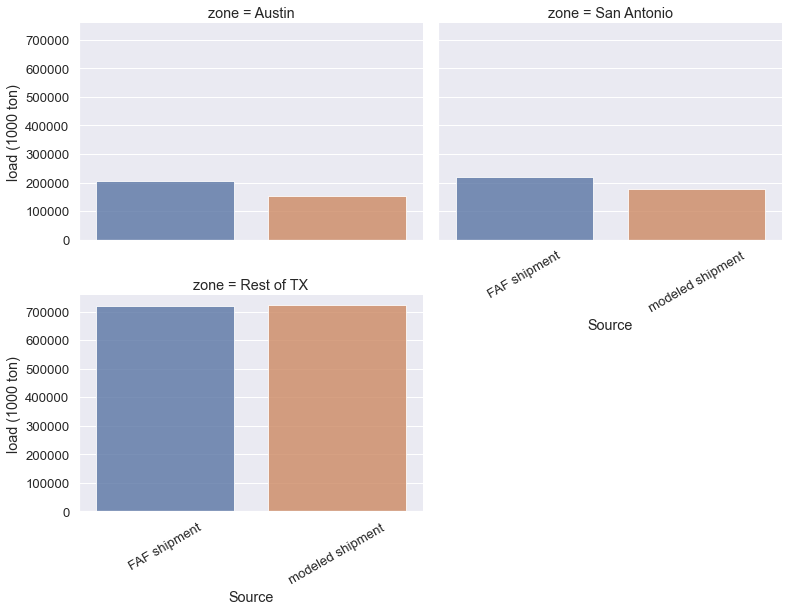

In [13]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_inflow_by_zone = bay_area_inflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_zone = agg_faf_inflow_by_zone.reset_index()

agg_modeled_inflow_by_zone = modeled_bay_area_inflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_by_zone = agg_modeled_inflow_by_zone.reset_index()
print(agg_modeled_inflow_by_zone)
                                                                      
compare_inflow_by_zone = pd.merge(agg_faf_inflow_by_zone, agg_modeled_inflow_by_zone, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')

compare_inflow_by_zone = compare_inflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_inflow_by_zone = pd.melt(compare_inflow_by_zone, 
                                        id_vars=['dms_dest', 'dest_FAFID', 'dest_FAFNAME'], 
                                        value_vars=['FAF shipment', 'modeled shipment'], 
                                        var_name = 'Source', ignore_index=False)
# print(compare_inflow_by_zone.head(5))
compare_inflow_by_zone = compare_inflow_by_zone.rename(columns = {'dest_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
ax = sns.catplot(
    data= compare_inflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot_aus_' + str(analysis_year) + '/inflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_zone.to_csv(c.output_dir + 'compare_inflow_by_zone_cfs_dded.csv', sep = ',')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


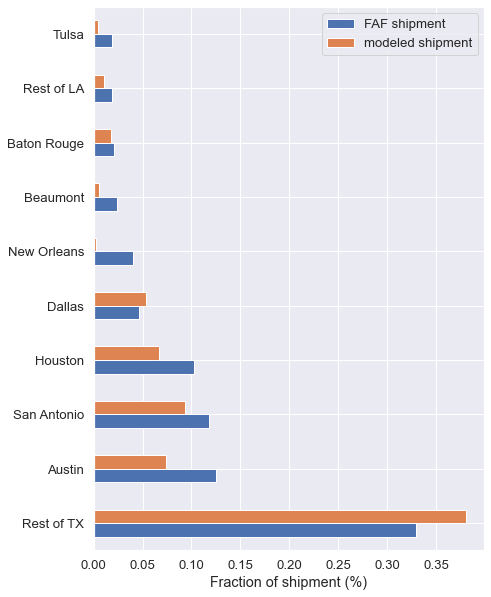

In [14]:
# plot outflow distance and tonnage distribution
nzones = 10
agg_faf_outflow_by_destination = bay_area_outflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_bay_area_outflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')


compare_outflow_by_destination = \
compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})
compare_outflow_by_destination.loc[:, 'FAF shipment'] = \
compare_outflow_by_destination.loc[:, 'FAF shipment'] / compare_outflow_by_destination.loc[:, 'FAF shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled shipment'] = \
compare_outflow_by_destination.loc[:, 'modeled shipment'] / compare_outflow_by_destination.loc[:, 'modeled shipment'].sum()

# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('Plot_aus_' + str(analysis_year) + '/percent_outflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


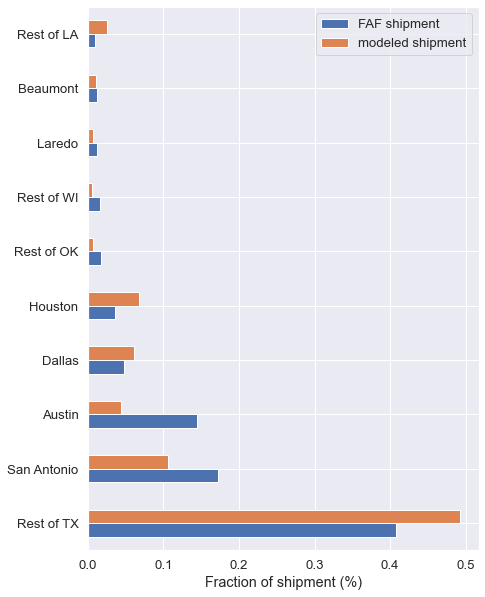

In [16]:
# plot inflow distance and tonnage distribution
nzones = 10
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')



compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})


compare_inflow_by_origin.loc[:, 'FAF shipment'] = compare_inflow_by_origin.loc[:, 'FAF shipment'] / compare_inflow_by_origin.loc[:, 'FAF shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled shipment'] = compare_inflow_by_origin.loc[:, 'modeled shipment'] / compare_inflow_by_origin.loc[:, 'modeled shipment'].sum()

# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('Plot_aus_' + str(analysis_year) + '/percent_inflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()
